In [9]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchdiffeq import odeint
import sympy as sp
from scipy.integrate import solve_ivp


In [10]:

# === Seed for reproducibility
np.random.seed(1111)
torch.manual_seed(1111)

In [11]:

# === Lotka-Volterra Ground Truth
def lotka_volterra(t, u, p):
    x, y = u
    alpha, beta, gamma, delta = p
    dxdt = alpha * x - beta * x * y
    dydt = gamma * x * y - delta * y
    return np.array([dxdt, dydt])

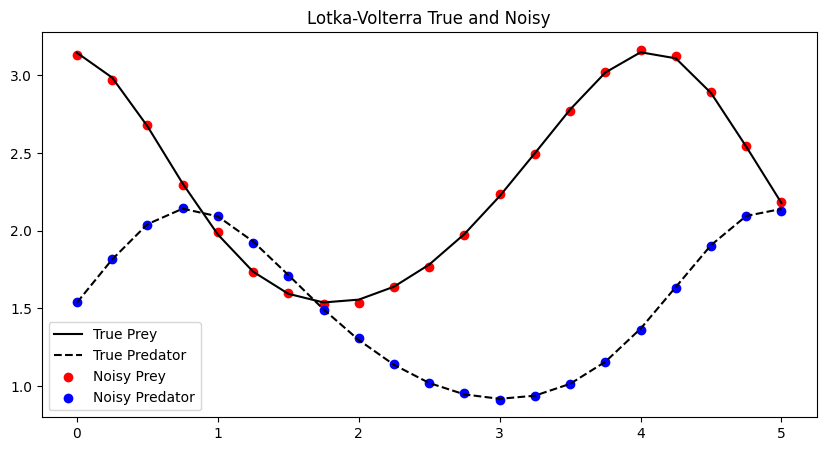

In [12]:

# === Parameters
p_true = [1.3, 0.9, 0.8, 1.8]
u0 = np.array([3.146, 1.537])
t_eval = np.arange(0, 5.01, 0.25)

# === Solve ODE
sol = solve_ivp(lambda t, u: lotka_volterra(t, u, p_true), (0, 5), u0, t_eval=t_eval, atol=1e-12, rtol=1e-12)
X = sol.y
x_mean = np.mean(X, axis=1, keepdims=True)
Xn = X + 5e-3 * x_mean * np.random.randn(*X.shape)

# === Plot Noisy vs True
plt.figure(figsize=(10, 5))
plt.plot(t_eval, X[0], label="True Prey", color='black')
plt.plot(t_eval, X[1], label="True Predator", color='black', linestyle='--')
plt.scatter(t_eval, Xn[0], label="Noisy Prey", color='red')
plt.scatter(t_eval, Xn[1], label="Noisy Predator", color='blue')
plt.legend(); plt.title("Lotka-Volterra True and Noisy"); plt.show()

In [13]:

# === Torch Tensors
Xn_tensor = torch.tensor(Xn.T, dtype=torch.float32)
t_tensor = torch.tensor(t_eval, dtype=torch.float32)

# === Neural Network for Interaction Terms
class InteractionNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 5), nn.GELU(),
            nn.Linear(5, 5), nn.GELU(),
            nn.Linear(5, 2)
        )
    def forward(self, x):
        return self.net(x)

interaction_net = InteractionNN()

# === UDE ODE Definition
class UDEFunc(nn.Module):
    def __init__(self, interaction_net, alpha, delta):
        super().__init__()
        self.interaction_net = interaction_net
        self.alpha = alpha
        self.delta = delta
    def forward(self, t, u):
        interaction = self.interaction_net(u)
        dx = self.alpha * u[:, 0] + interaction[:, 0]
        dy = -self.delta * u[:, 1] + interaction[:, 1]
        return torch.stack([dx, dy], dim=1)

ude_func = UDEFunc(interaction_net, alpha=p_true[0], delta=p_true[3])

# === Loss Function
def compute_loss(model, Xn, t_eval):
    pred = odeint(model, Xn[0:1], t_eval, method='dopri5')
    return torch.mean((pred.squeeze() - Xn)**2)

# === Train with Adam
loss_history_adam = []
def train_model(model, Xn, t_eval, epochs=2000, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = compute_loss(model, Xn, t_eval)
        loss.backward()
        optimizer.step()
        loss_history_adam.append(loss.item())
        if epoch % 200 == 0:
            print(f"[Adam] Epoch {epoch}, Loss: {loss.item():.6f}")

# === Fine-tune with L-BFGS
def fine_tune_lbfgs(model, Xn, t_eval):
    optimizer = optim.LBFGS(model.parameters(), max_iter=500, line_search_fn="strong_wolfe")
    def closure():
        optimizer.zero_grad()
        loss = compute_loss(model, Xn, t_eval)
        loss.backward()
        return loss
    print("🔁 L-BFGS optimizing...")
    optimizer.step(closure)
    print(f"✅ Final Loss: {compute_loss(model, Xn, t_eval).item():.6f}")


[Adam] Epoch 0, Loss: 223415.140625
[Adam] Epoch 200, Loss: 14989.837891
[Adam] Epoch 400, Loss: 2746.070801
[Adam] Epoch 600, Loss: 841.119263
[Adam] Epoch 800, Loss: 317.252167
[Adam] Epoch 1000, Loss: 128.804520
[Adam] Epoch 1200, Loss: 53.498234
[Adam] Epoch 1400, Loss: 22.450626
[Adam] Epoch 1600, Loss: 9.706657
[Adam] Epoch 1800, Loss: 4.631955
🔁 L-BFGS optimizing...
✅ Final Loss: 0.000063


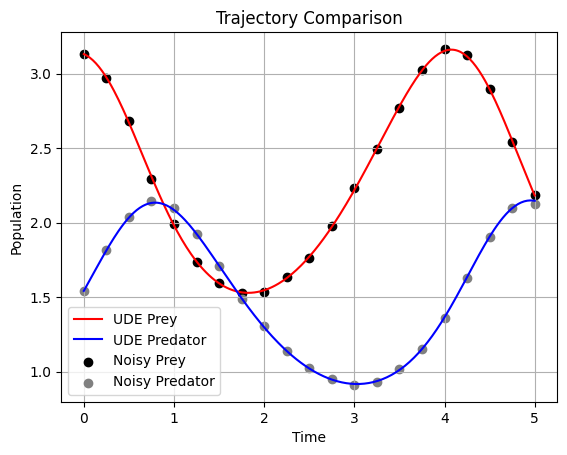

[Adam Sparse] Epoch 0, Loss: 21.405495
[Adam Sparse] Epoch 2000, Loss: 0.022362
[Adam Sparse] Epoch 4000, Loss: 0.020018
[Adam Sparse] Epoch 6000, Loss: 0.019430
[Adam Sparse] Epoch 8000, Loss: 0.018974
[Adam Sparse] Epoch 10000, Loss: 0.018641
[Adam Sparse] Epoch 12000, Loss: 0.018318
[Adam Sparse] Epoch 14000, Loss: 0.018061


tensor(0.0179, grad_fn=<AddBackward0>)

In [14]:

# === Train Model
train_model(ude_func, Xn_tensor, t_tensor)
fine_tune_lbfgs(ude_func, Xn_tensor, t_tensor)

# === Predict on Dense Time Grid
t_dense = torch.linspace(t_tensor[0], t_tensor[-1], 300)
X_hat = odeint(ude_func, Xn_tensor[0:1], t_dense, method='dopri5').squeeze().detach().numpy().T

# === Plot Predicted vs Noisy
plt.figure()
plt.plot(t_dense, X_hat[0], label='UDE Prey', color='red')
plt.plot(t_dense, X_hat[1], label='UDE Predator', color='blue')
plt.scatter(t_eval, Xn[0], label='Noisy Prey', color='black')
plt.scatter(t_eval, Xn[1], label='Noisy Predator', color='gray')
plt.title("Trajectory Comparison"); plt.xlabel("Time"); plt.ylabel("Population")
plt.legend(); plt.grid(); plt.show()

# === Compare Interaction Terms
X_hat_tensor = torch.tensor(X_hat.T, dtype=torch.float32)
with torch.no_grad():
    Y_hat = interaction_net(X_hat_tensor).numpy().T
x, y = X_hat
Y_true = np.vstack([
    -p_true[1] * x * y,
     p_true[2] * x * y
])

# === Sparse Polynomial Expression Extraction
def symbolic_basis(x, y):
    return torch.stack([
        x, x**2, x**3, x**4,
        y, x*y, x**2*y, x**3*y,
        y**2, y**2*x, y**2*x**2,
        y**3, y**3*x, y**4
    ], dim=1)

x_pred = torch.tensor(X_hat[0], dtype=torch.float32)
y_pred = torch.tensor(X_hat[1], dtype=torch.float32)
Φ_tensor = symbolic_basis(x_pred, y_pred)
Y_hat_tensor = torch.tensor(Y_hat.T, dtype=torch.float32)
target_dx = Y_hat_tensor[:, 0]
target_dy = Y_hat_tensor[:, 1]

coeff_dx = torch.nn.Parameter(torch.zeros(Φ_tensor.shape[1]))
coeff_dy = torch.nn.Parameter(torch.zeros(Φ_tensor.shape[1]))

optimizer = torch.optim.Adam([coeff_dx, coeff_dy], lr=1e-3)
lambda_l1 = 1e-2

loss_history_sparse = []

for epoch in range(15000):
    optimizer.zero_grad()
    pred_dx = Φ_tensor @ coeff_dx
    pred_dy = Φ_tensor @ coeff_dy
    loss = (
        torch.mean((pred_dx - target_dx)**2) + lambda_l1 * torch.norm(coeff_dx, 1) +
        torch.mean((pred_dy - target_dy)**2) + lambda_l1 * torch.norm(coeff_dy, 1)
    )
    loss.backward()
    optimizer.step()
    loss_history_sparse.append(loss.item())
    if epoch % 2000 == 0:
        print(f"[Adam Sparse] Epoch {epoch}, Loss: {loss.item():.6f}")

# === L-BFGS Final Tune
def lbfgs_closure():
    lbfgs_optimizer.zero_grad()
    pred_dx = Φ_tensor @ coeff_dx
    pred_dy = Φ_tensor @ coeff_dy
    loss = (
        torch.mean((pred_dx - target_dx)**2) + lambda_l1 * torch.norm(coeff_dx, 1) +
        torch.mean((pred_dy - target_dy)**2) + lambda_l1 * torch.norm(coeff_dy, 1)
    )
    loss.backward()
    return loss

lbfgs_optimizer = torch.optim.LBFGS([coeff_dx, coeff_dy], max_iter=500, line_search_fn='strong_wolfe')
lbfgs_optimizer.step(lbfgs_closure)



📘 Final symbolic expression for dx interaction:
f₁(u₁,u₂) ≈ 0.00143521500285715*u₁**4 - 0.0735631436109543*u₁**2*u₂ - 0.0173511896282434*u₁**2 - 0.473179996013641*u₁*u₂ - 0.126455411314964*u₁ - 0.181895941495895*u₂**2 - 0.0491401180624962*u₂

📘 Final symbolic expression for dy interaction:
f₂(u₁,u₂) ≈ -0.00165066542103887*u₁**4 + 0.0643548890948296*u₁**2*u₂ + 0.475407749414444*u₁*u₂ + 0.132288530468941*u₁ + 0.124776862561703*u₂**2 + 0.0203537195920944*u₂


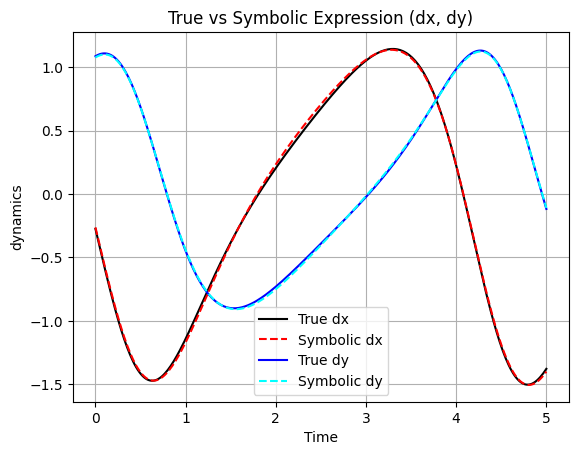

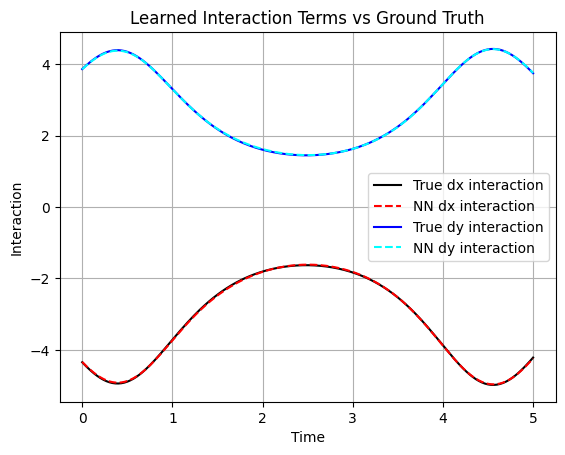

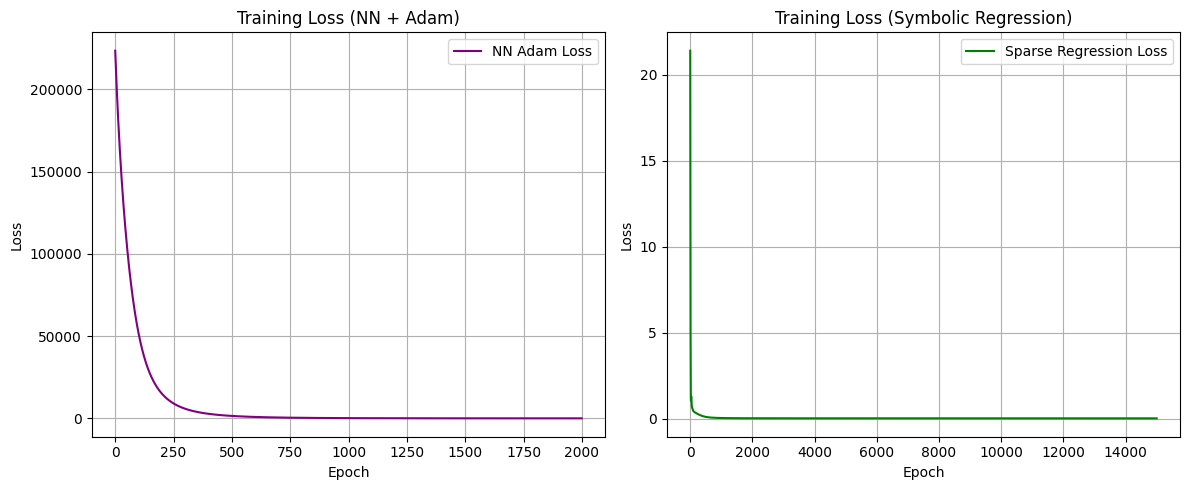

In [15]:

# === Final Symbolic Expressions
u1, u2 = sp.symbols("u₁ u₂")
basis_exprs = [
    u1, u1**2, u1**3, u1**4,
    u2, u1*u2, u1**2*u2, u1**3*u2,
    u2**2, u2**2*u1, u2**2*u1**2,
    u2**3, u2**3*u1, u2**4
]

def format_expression(coeffs, basis_exprs, threshold=1e-3):
    return sp.simplify(sum(c * e for c, e in zip(coeffs, basis_exprs) if abs(c) > threshold))

expr_dx = format_expression(coeff_dx.detach().numpy(), basis_exprs)
expr_dy = format_expression(coeff_dy.detach().numpy(), basis_exprs)

print("\n📘 Final symbolic expression for dx interaction:")
print("f₁(u₁,u₂) ≈", expr_dx)

print("\n📘 Final symbolic expression for dy interaction:")
print("f₂(u₁,u₂) ≈", expr_dy)

# === Plot Actual vs Symbolic (Full expression with known terms)
dx_true = p_true[0]*x + Y_true[0]
dx_pred = p_true[0]*x + (Φ_tensor @ coeff_dx).detach().numpy()

dy_true = -p_true[3]*y + Y_true[1]
dy_pred = -p_true[3]*y + (Φ_tensor @ coeff_dy).detach().numpy()

plt.figure()
plt.plot(t_dense, dx_true, label='True dx', color='black')
plt.plot(t_dense, dx_pred, '--', label='Symbolic dx', color='red')
plt.plot(t_dense, dy_true, label='True dy', color='blue')
plt.plot(t_dense, dy_pred, '--', label='Symbolic dy', color='cyan')
plt.title("True vs Symbolic Expression (dx, dy)")
plt.xlabel("Time"); plt.ylabel("dynamics")
plt.legend(); plt.grid(); plt.show()

plt.figure()
plt.plot(t_dense, Y_true[0], label='True dx interaction', color='black')
plt.plot(t_dense, Y_hat[0], '--', label='NN dx interaction', color='red')
plt.plot(t_dense, Y_true[1], label='True dy interaction', color='blue')
plt.plot(t_dense, Y_hat[1], '--', label='NN dy interaction', color='cyan')
plt.title("Learned Interaction Terms vs Ground Truth")
plt.xlabel("Time"); plt.ylabel("Interaction")
plt.legend(); plt.grid(); plt.show()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_history_adam, label='NN Adam Loss', color='purple')
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("Training Loss (NN + Adam)")
plt.grid(); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss_history_sparse, label='Sparse Regression Loss', color='green')
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("Training Loss (Symbolic Regression)")
plt.grid(); plt.legend()

plt.tight_layout()
plt.show()

